### Installation

In [1]:
!pip install pytorch-lightning lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 6.1 MB/s eta 0:00:00a 0:00:01


### Import

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

from torchmetrics import Accuracy

import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

## MODEL

In [3]:
PATH_DATASETS = '/kaggle/working/'

In [4]:
class LitMNIST(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4):
        super().__init__()

        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr

        self.class_names = [0, 1, 2, 3, 4]
        self.min_class = min(self.class_names)
        self.num_classes = len(self.class_names)
        self.dims = (1, 28, 28) # channel x width x height
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.batch_size = 1024

        self.l1 = nn.Linear(channels * width * height, self.hidden_size)
        self.l2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.l3 = nn.Linear(self.hidden_size, self.num_classes)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)

        # layer 1
        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 2
        x = self.l2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 3
        x = self.l3(x)

        return F.log_softmax(x, dim=1) # log probs

    def common_step(self, batch, batch_idx):
        x, y = batch

        if self.min_class != 0:
            y = y - self.min_class

        logits = self(x)
        loss = F.nll_loss(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = self.val_accuracy(preds, y)
        return x, y, logits, loss

    def training_step(self, batch, batch_idx):
        _, _, _, loss = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

    ## HELPER FUNCTIONS
    @staticmethod
    def get_indices(dataset, class_names):
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets

        indices = []
        for i in range(len(targets)):
            if targets[i] in class_names:
                indices.append(i)
        return indices

    def create_dataloader(self, dataset):
        idx = self.get_indices(dataset, self.class_names)
        loader = DataLoader(dataset, batch_size=self.batch_size, sampler=SubsetRandomSampler(idx), num_workers=16)
        return loader
    
    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
    
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)

    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)

    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)

In [5]:
model = LitMNIST()
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="/kaggle/working/MNIST_logs/"),
)

trainer.fit(model)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 31750902.48it/s]


Extracting /kaggle/working/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 948870.81it/s]


Extracting /kaggle/working/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8885665.79it/s]


Extracting /kaggle/working/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2497447.40it/s]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Extracting /kaggle/working/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw



INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
54.7 K    Trainable params
0         Non-trainable params
54.7 K    Total params
0.219     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


,train_loss,val_acc,val_loss
epoch,,,
0,NaN,0.698130,0.998490
1,0.552943,NaN,NaN
1,NaN,0.879795,0.431076
2,NaN,0.918667,0.251940
3,0.222945,NaN,NaN


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


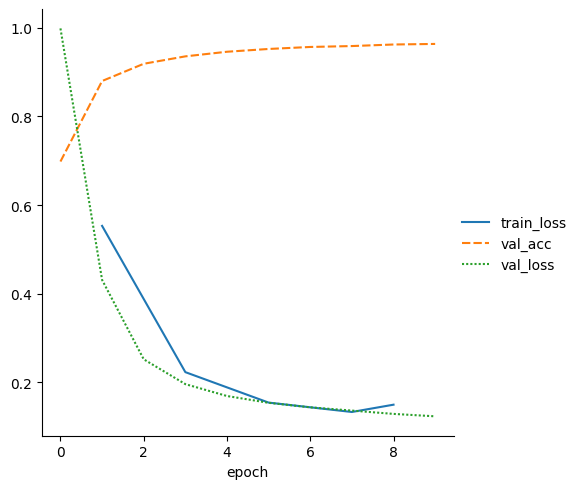

In [6]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sns.relplot(data=metrics, kind="line")

In [7]:
trainer.test()

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /kaggle/working/MNIST_logs/lightning_logs/version_0/checkpoints/epoch=9-step=280.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/MNIST_logs/lightning_logs/version_0/checkpoints/epoch=9-step=280.ckpt
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9739248752593994     │
│         test_loss         │    0.08708629757165909    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08708629757165909, 'test_acc': 0.9739248752593994}]

In [8]:
MODEL_PATH = "/kaggle/working/MNIST_models/"

In [9]:
trainer.save_checkpoint(f"{MODEL_PATH}model.ckpt")
torch.save(model.state_dict(), f"{MODEL_PATH}model.pt")

## Finetuning (FT)

In [19]:
model_loaded_no_training = LitMNIST.load_from_checkpoint(checkpoint_path=f"{MODEL_PATH}model.ckpt")
model_loaded_no_training.class_names= [5,6,7,8,9]
model_loaded_no_training.min_class = min(model_loaded_no_training.class_names)

# we will train on the new data on exactly one element once (this is so we can access the trainer2.test() function, which allows us to easily evaluate how well our model works on the new data prior to training)
model_loaded_no_training.batch_size = 1
trainer_no_train = L.Trainer(
    accelerator="auto",
    devices=1,
    max_steps=1,
    logger=CSVLogger(save_dir="/kaggle/working/MNIST_logs/"),
)
trainer_no_train.fit(model_loaded_no_training)
# we can see our model performs extremely poorly on the new data that it hasn't seen, which is unsuprising. 
trainer_no_train.test()

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
54.7 K    Trainable params
0         Non-trainable params
54.7 K    Total params
0.219     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=1` reached.
INFO: Restoring states from the checkpoint path at /kaggle/working/MNIST_logs/lightning_logs/version_1/checkpoints/epoch=0-step=1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/MNIST_logs/lightning_logs/version_1/checkpoints/epoch=0-step=1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.34190496802330017    │
│         test_loss         │    3.0188493728637695     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.0188493728637695, 'test_acc': 0.34190496802330017}]

In [21]:
# now finetune e2e on the new data
model_5_9 = LitMNIST.load_from_checkpoint(checkpoint_path=f"{MODEL_PATH}model.ckpt")
# set it up to run on the second half of mnist (digits 5,6,7,8,9)
model_loaded_no_training.class_names= [5,6,7,8,9]
model_loaded_no_training.min_class = min(model_loaded_no_training.class_names)

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=10,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model_5_9)

# unsuprisingly finetuning allows us to perform equally well on the second half of MNIST. However this approach would require us to save the ENTIRE model binary for each dataset we wanted to finetune our initial model on, which doesn't scale well.
trainer.test()

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
54.7 K    Trainable params
0         Non-trainable params
54.7 K    Total params
0.219     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO: Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=9-step=280.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=9-step=280.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9848219752311707     │
│         test_loss         │    0.05087530240416527    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.05087530240416527, 'test_acc': 0.9848219752311707}]

## Finetuning using matrix-transformations

In [13]:
class LitMNIST_FMT(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4):
        super().__init__()
        
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr
        
        self.class_names = [0,1,2,3,4]
        self.min_class = min(self.class_names)
        self.num_classes = len(self.class_names)
        self.dims = (1,28,28)
        channels, width, height = self.dims
        
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
        self.batch_size = 64
        self.l1 = nn.Linear(channels*width*height, self.hidden_size)
        self.l2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.l3 = nn.Linear(self.hidden_size, self.num_classes)
        
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        
        # Full Matrix Transform Params
        
        # layer-i of shape nxm has a Matrix-transform of shape nxn
        self.l1_mt = nn.Parameter(torch.eye(channels*width*height))
        self.l2_mt = nn.Parameter(torch.eye(self.hidden_size))
        self.l3_mt = nn.Parameter(torch.eye(self.hidden_size))
        
        # to not learn the other params
        for n, p in self.named_parameters():
            if 'mt' not in n:
                p.requires_grad = False
            
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)        
        
    def mt_linear(self, x, layer, layer_mt):
        h = layer(x @ layer_mt)
        return h
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        
        # layer 1
        x = self.mt_linear(x, self.l1, self.l1_mt)
        x = self.relu(x)
        x = self.dropout(x)
        
        # layer 2
        x = self.mt_linear(x, self.l2, self.l2_mt)
        x = self.relu(x)
        x = self.dropout(x)
        
        # layer 3
        x = self.mt_linear(x, self.l3, self.l3_mt)
        
        return F.log_softmax(x, dim=1) # log probs
    
    def common_step(self, batch, batch_idx):
        x, y = batch
        if self.min_class != 0:
            y = y - self.min_class
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return x, y, logits, loss
    
    def training_step(self, batch, batch_idx):
        _,_,_,loss = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, batch_size=self.batch_size)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        
        self.log("val_loss", loss, prog_bar=False)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=10)
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
            }
        }
    
    @staticmethod
    def get_indices(dataset, class_names):
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets
        
        indices = []
        for i in range(len(targets)):
            if targets[i] in class_names:
                indices.append(i)
        
        return indices
    
    def create_dataloader(self,dataset):
        idx = self.get_indices(dataset, self.class_names)
        loader = DataLoader(dataset,batch_size=self.batch_size, sampler = SubsetRandomSampler(idx), num_workers=16)
        return loader

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)

    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)

    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)

In [15]:
state_dict = torch.load(f"{MODEL_PATH}model.pt")
model = LitMNIST_FMT()
model.load_state_dict(state_dict, strict=False)

/tmp/ipykernel_36/1989261238.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"{MODEL_PATH}model.pt")


_IncompatibleKeys(missing_keys=['l1_mt', 'l2_mt', 'l3_mt'], unexpected_keys=[])

In [16]:
model.class_names= [5,6,7,8,9]
model.min_class = min(model.class_names)

In [17]:
from lightning.pytorch.callbacks import LearningRateMonitor
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=500,
    callbacks=[lr_monitor, EarlyStopping(monitor="val_loss", mode="min", patience=10)],

    enable_progress_bar = True
)

trainer.fit(model)
print(trainer.test()[0]['test_acc'])

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 622 K  | n/a  
-------------------------------------------------------------
622 K     Trainable params
54.7 K    Non-trainable params
677 K     Total params
2.710     Total estimated model params size (MB)
7         Modules in train mode
0         Modules i

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_1/checkpoints/epoch=26-step=11367.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_1/checkpoints/epoch=26-step=11367.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.982925295829773     │
│         test_loss         │    0.07487928867340088    │
└───────────────────────────┴───────────────────────────┘

0.982925295829773


## Finetuning using Matrix-tranformations-low-rank-adaptations

In [18]:
class LitMNIST_FMT_LoRA(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=64, lr=2e-4, lora_rank=4):
        super().__init__()
        
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.lr = lr
        self.lora_rank = lora_rank
        
        self.class_names = [0,1,2,3,4]
        self.min_class = min(self.class_names)
        self.num_classes = len(self.class_names)
        self.dims = (1,28,28)
        channels, width, height = self.dims
        
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
        self.batch_size = 64
        self.l1 = nn.Linear(channels*width*height, self.hidden_size)
        self.l2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.l3 = nn.Linear(self.hidden_size, self.num_classes)
        
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        
        # Full Matrix LoRA Transform Params
        
        # layer-i of shape nxm has a Matrix-transform of shape nxn
        self.l1_mt_lora_A = nn.Parameter(torch.empty(channels*width*height, self.lora_rank))
        self.l1_mt_lora_B = nn.Parameter(torch.empty(self.lora_rank, channels*width*height))
        
        self.l2_mt_lora_A = nn.Parameter(torch.empty(self.hidden_size, self.lora_rank))
        self.l2_mt_lora_B = nn.Parameter(torch.empty(self.lora_rank, self.hidden_size))
        
        self.l3_mt_lora_A = nn.Parameter(torch.empty(self.hidden_size, self.lora_rank))
        self.l3_mt_lora_B = nn.Parameter(torch.empty(self.lora_rank, self.hidden_size))
        
        self.initialize_lora_parameters()
        
        # freeze learned params
        for n, p in self.named_parameters():
            if "mt_lora" not in n:
                p.requires_grad = False
        
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)       

    def initialize_lora_parameters(self):
        # Helper function to initialize A and B to approximate identity
        def init_lora_matrices(A, B):
            nn.init.kaiming_uniform_(A, a=math.sqrt(5))
            with torch.no_grad():
                A_t = A.t()
                B.copy_(torch.matmul(torch.inverse(torch.matmul(A_t, A)), A_t))

        init_lora_matrices(self.l1_mt_lora_A, self.l1_mt_lora_B)
        init_lora_matrices(self.l2_mt_lora_A, self.l2_mt_lora_B)
        init_lora_matrices(self.l3_mt_lora_A, self.l3_mt_lora_B) 
        
    def mt_linear(self, x, layer, layer_mt_lora_A, layer_mt_lora_B):
        h = layer(x @ layer_mt_lora_A @ layer_mt_lora_B)
        return h
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        
        # layer 1
        x = self.mt_linear(x, self.l1, self.l1_mt_lora_A, self.l1_mt_lora_B)
        x = self.relu(x)
        x = self.dropout(x)
        
        # layer 2
        x = self.mt_linear(x, self.l2, self.l2_mt_lora_A, self.l2_mt_lora_B)
        x = self.relu(x)
        x = self.dropout(x)
        
        # layer 3
        x = self.mt_linear(x, self.l3, self.l3_mt_lora_A, self.l3_mt_lora_B)
        
        return F.log_softmax(x, dim=1) # log probs
    
    def common_step(self, batch, batch_idx):
        x, y = batch
        if self.min_class != 0:
            y = y - self.min_class
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return x, y, logits, loss
    
    def training_step(self, batch, batch_idx):
        _,_,_,loss = self.common_step(batch, batch_idx)
        self.log("train_loss", loss, batch_size=self.batch_size)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        
        self.log("val_loss", loss, prog_bar=False)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        x, y, logits, loss = self.common_step(batch, batch_idx)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=10)
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
            }
        }
    
    @staticmethod
    def get_indices(dataset, class_names):
        if isinstance(dataset, torch.utils.data.dataset.Subset):
            targets = torch.tensor([dataset.dataset.targets[i] for i in dataset.indices])
        else:
            targets = dataset.targets
        
        indices = []
        for i in range(len(targets)):
            if targets[i] in class_names:
                indices.append(i)
        
        return indices
    
    def create_dataloader(self,dataset):
        idx = self.get_indices(dataset, self.class_names)
        loader = DataLoader(dataset,batch_size=self.batch_size, sampler = SubsetRandomSampler(idx), num_workers=16)
        return loader

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return self.create_dataloader(self.mnist_train)

    def val_dataloader(self):
        return self.create_dataloader(self.mnist_val)

    def test_dataloader(self):
        return self.create_dataloader(self.mnist_test)

In [19]:
def mt_lora_experiment(rank):
    state_dict = torch.load(f"{MODEL_PATH}model.pt")
    model = LitMNIST_FMT_LoRA(lora_rank=rank)
    model.load_state_dict(state_dict, strict=False)
    model.class_names= [5,6,7,8,9]
    model.min_class = min(model.class_names)
    
    from lightning.pytorch.callbacks import LearningRateMonitor
    lr_monitor = LearningRateMonitor(logging_interval='step')
    
    trainer = L.Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=100,
        callbacks=[lr_monitor, EarlyStopping(monitor="val_loss", mode="min", patience=10)],

        enable_progress_bar=True
    )
    
    trainer.fit(model)
    return trainer.test()[0]['test_acc']

In [20]:
results = {}
for rank in [1, 2, 4, 8, 16, 32, 64]:
    result = mt_lora_experiment(rank)
    results[rank] = result
    print(results)

/tmp/ipykernel_36/2940126208.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"{MODEL_PATH}model.pt")
INFO: GPU available: True (cuda), used: Tru

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_2/checkpoints/epoch=99-step=42200.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_2/checkpoints/epoch=99-step=42200.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4040320813655853     │
│         test_loss         │    0.9450168609619141     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


{1: 0.4040320813655853}


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 3.6 K  | n/a  
-------------------------------------------------------------
3.6 K     Trainable params
54.7 K    Non-trainable params
58.4 K    Total params
0.233     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_3/checkpoints/epoch=99-step=42200.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_3/checkpoints/epoch=99-step=42200.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8942604660987854     │
│         test_loss         │    0.34676364064216614    │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


{1: 0.4040320813655853, 2: 0.8942604660987854}


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 7.3 K  | n/a  
-------------------------------------------------------------
7.3 K     Trainable params
54.7 K    Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_4/checkpoints/epoch=96-step=40837.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_4/checkpoints/epoch=96-step=40837.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9518617391586304     │
│         test_loss         │    0.15673291683197021    │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


{1: 0.4040320813655853, 2: 0.8942604660987854, 4: 0.9518617391586304}


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 14.6 K | n/a  
-------------------------------------------------------------
14.6 K    Trainable params
54.7 K    Non-trainable params
69.3 K    Total params
0.277     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_5/checkpoints/epoch=83-step=35448.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_5/checkpoints/epoch=83-step=35448.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9677020907402039     │
│         test_loss         │    0.10790698975324631    │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


{1: 0.4040320813655853, 2: 0.8942604660987854, 4: 0.9518617391586304, 8: 0.9677020907402039}


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 29.2 K | n/a  
-------------------------------------------------------------
29.2 K    Trainable params
54.7 K    Non-trainable params
83.9 K    Total params
0.336     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_6/checkpoints/epoch=65-step=27852.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_6/checkpoints/epoch=65-step=27852.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9763423204421997     │
│         test_loss         │    0.09098241478204727    │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


{1: 0.4040320813655853, 2: 0.8942604660987854, 4: 0.9518617391586304, 8: 0.9677020907402039, 16: 0.9763423204421997}


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 58.4 K | n/a  
-------------------------------------------------------------
58.4 K    Trainable params
54.7 K    Non-trainable params
113 K     Total params
0.452     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_7/checkpoints/epoch=40-step=17261.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_7/checkpoints/epoch=40-step=17261.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9759308695793152     │
│         test_loss         │    0.09329970180988312    │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


{1: 0.4040320813655853, 2: 0.8942604660987854, 4: 0.9518617391586304, 8: 0.9677020907402039, 16: 0.9763423204421997, 32: 0.9759308695793152}


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | l1            | Linear             | 50.2 K | train
1 | l2            | Linear             | 4.2 K  | train
2 | l3            | Linear             | 325    | train
3 | dropout       | Dropout            | 0      | train
4 | relu          | ReLU               | 0      | train
5 | val_accuracy  | MulticlassAccuracy | 0      | train
6 | test_accuracy | MulticlassAccuracy | 0      | train
  | other params  | n/a                | 116 K  | n/a  
-------------------------------------------------------------
116 K     Trainable params
54.7 K    Non-trainable params
171 K     Total params
0.686     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_8/checkpoints/epoch=18-step=8018.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_8/checkpoints/epoch=18-step=8018.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9709936380386353     │
│         test_loss         │    0.1653660535812378     │
└───────────────────────────┴───────────────────────────┘

{1: 0.4040320813655853, 2: 0.8942604660987854, 4: 0.9518617391586304, 8: 0.9677020907402039, 16: 0.9763423204421997, 32: 0.9759308695793152, 64: 0.9709936380386353}


In [32]:
results_df = pd.DataFrame(list(results.items()), columns=['Global Rank(r) for MT-LoRA', 'test_accuracy (MT-LoRA)'])
results_df['#trainable_params'] = 784 * results_df['Global Rank(r) for MT-LoRA'] * 2 + 64 * results_df['Global Rank(r) for MT-LoRA'] * 4
results_df['#model_params'] = 54700
results_df['test_accuracy (FineTuning)'] = 0.9848219752311707
results_df['test_accuracy (FineTuning)'] = 0.982925295829773
results_df['test_accuracy (LoRA)'] = [ 0.874717116355896, 0.9314955472946167, 0.9639991521835327, 0.9709936380386353, 0.9765480160713196, 0.9796338081359863, 0.9804567098617554]
results_df[['Global Rank(r) for MT-LoRA', '#model_params', '#trainable_params', 'test_accuracy (MT-LoRA)', 'test_accuracy (LoRA)', 'test_accuracy (FineTuning)', 'test_accuracy (FineTuning)']]

,Global Rank(r) for MT-LoRA,#model_params,#trainable_params,test_accuracy (MT-LoRA),test_accuracy (LoRA),test_accuracy (FineTuning),test_accuracy (FineTuning)
0,1,54700,1824,0.404032,0.874717,0.982925,0.982925
1,2,54700,3648,0.894260,0.931496,0.982925,0.982925
2,4,54700,7296,0.951862,0.963999,0.982925,0.982925
3,8,54700,14592,0.967702,0.970994,0.982925,0.982925
4,16,54700,29184,0.976342,0.976548,0.982925,0.982925
5,32,54700,58368,0.975931,0.979634,0.982925,0.982925
6,64,54700,116736,0.970994,0.980457,0.982925,0.982925
